In [1]:
import numpy as np
from collections import OrderedDict
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe

# This silent device placement will hurt performance on GPUs, but we are sticking to CPUs only so it
# should be fine
tf.enable_eager_execution()
tf.set_random_seed(0)

d:\users\yue\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Goal
We are going to implement the JANet model from the paper ["The unreasonable effectiveness of the forget gate"](https://arxiv.org/abs/1804.04849) and try the addition experiment to see if it converges properly. 

This is not going to be a high performance model, nor will it probably match the performance of the paper. This is going to be a simple exercise in how easy it is to write down research models in Tensorflow Eager without all the baggage of Tensorflow graphs.

# Components we need
For JANet, we need two components :

1) Chrono Initializer from the paper [Can recurrent neural networks warp time? ](https://openreview.net/forum?id=SJcKhk-Ab)

2) The RNN cell which will do most of the work

Lets create the initializer first since it is simpler

# Chrono Initializer
In short, if we know the length of the sequence in the range $[T_{min}, T_{max}]$, then it would be beneficial to initialize the model with a forgetting time in the same range. Therefore, this would be equivalent to initialize the gate $g$ in the range $[\frac{1}{T_{max}}, \frac{1}{T_{min}}]$.

If the values of both inputs and hidden layers are centered over time, $g(t)$ will typically take values centered around $\sigma(b_g)$. To obtain values in the desired range above, the biases $b_g$ must be in the range $-log(T_{max} - 1)$ and $-log(T_{min} - 1)$.

For the $t$th time step, the forget gate $f_t$ corresponds to $1 - g_t$, where as the input gate $i_t$ corresponds to $g_t$ in an LSTM RNN. Letting the minimum number of timesteps to be 1 and maximum to be $T_{max}$, the paper suggests initializing the forget gate and input gate as follows : 

\begin{align}
b_f &\sim log(U([1, T_{max}]) - 1) \\\
b_i &= -b_f
\end{align}

For a complete explanation of ChronoInitializer, refer to the above paper.


In [3]:
if tfe.num_gpus() > 0:
    _device = '/gpu:0'
else:
    _device = '/cpu:0'

In [4]:
class ChronoInitializer(tf.keras.initializers.RandomUniform):
    """
    Chrono Initializer from the paper :
    [Can recurrent neural networks warp time?](https://openreview.net/forum?id=SJcKhk-Ab)
    """

    def __init__(self, max_timesteps, seed=None):
        super(ChronoInitializer, self).__init__(1., max_timesteps - 1, seed)
        self.max_timesteps = max_timesteps

    def __call__(self, shape, dtype=None, partition_info=None):
        values = super(ChronoInitializer, self).__call__(shape, dtype=dtype, partition_info=partition_info)
        return tf.log(values)

    def get_config(self):
        config = {
            'max_timesteps': self.max_timesteps
        }
        base_config = super(ChronoInitializer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# RNN Cell

The model described in the paper ["The unreasonable effectiveness of the forget gate"](https://arxiv.org/abs/1804.04849) is called JANet - a model where the forget $(g_f)$ gate alone is the one of two gates, alongside with the memory $(g_c)$ gate. It doesn't use the input $(g_i)$ and output $(g_o)$ gates.

In [5]:

class JANETModel(tf.keras.Model):

    def __init__(self, units, num_outputs, num_timesteps, output_activation='sigmoid', **kwargs):
        super(JANETModel, self).__init__(**kwargs)

        self.units = units
        self.classes = num_outputs
        self.num_timesteps = num_timesteps

        with tf.device(_device):
            # Initialize the forget gate with ChronoInitializer
            # The memory gate is initialized with zeros
            def bias_initializer(_, *args, **kwargs):
                forget_gate = ChronoInitializer(self.num_timesteps)((self.units,), *args, **kwargs)
    
                return tf.keras.backend.concatenate([
                    forget_gate,
                    tf.keras.initializers.Zeros()((self.units,), *args, **kwargs),
                ])
        
            # Initialize the hidden and recurrent gates
            self.kernel = tf.keras.layers.Dense(2 * units, use_bias=False,
                                                kernel_initializer='glorot_uniform')
            
            self.recurrent_kernel = tf.keras.layers.Dense(2 * units,
                                                          kernel_initializer='glorot_uniform',
                                                          bias_initializer=bias_initializer)
            
            # Initialize the final layer (for classification or regression depending on the output activation)
            self.output_dense = tf.keras.layers.Dense(num_outputs, activation=output_activation)
        
    """
    This is required to override a certain issue with how the weights of a model are loaded
    by a checkpoint.
    
    While we could use `model.call(inputs)` directly, the more pythonic way of doing this is
    by using `model(inputs)`.
    
    However, in Eager mode, the ordinary function call does *not* forward the method to the
    models `call` method. This bypasses that issue.
    """
    def __call__(self, *args, **kwargs):
        if not tf.executing_eagerly():
            super(JANETModel, self).__call__(*args, **kwargs)
        return self.call(*args, **kwargs)

    def call(self, inputs, training=None, mask=None):
        # Initialize the hidden memory states
        outputs = []
        states = []
        
        with tf.device(_device):
            h_state = tf.zeros((inputs.shape[0], self.units))
            c_state = tf.zeros((inputs.shape[0], self.units))
        
            # Input is in the shape [None, timesteps, input_dim]
            for t in range(inputs.shape[1]):
                ip = inputs[:, t, :]  # access the T'th timestep
                
                # Perform the forward pass of the model
                z = self.kernel(ip)
                z += self.recurrent_kernel(h_state)
    
                # Split the output into the forget and memory outputs
                z0 = z[:, :self.units]
                z1 = z[:, self.units: 2 * self.units]
    
                # gate updates
                f = tf.keras.activations.sigmoid(z0)
                c = f * c_state + (1. - f) * tf.nn.tanh(z1)
    
                # state updates
                h = c
    
                # update our previous state
                h_state = h
                c_state = c
            
                # preserve the history of our states
                outputs.append(h)
                states.append([h, c])  # here we maintain just 1 state variable, can be more
                
            # save memory states to global variables so we can access them later
            # self.cell_outputs = tf.stack(outputs, axis=1)
            # self.cell_states = states
            
            # perform forward pass of the classifier / regressor
            preds = self.output_dense(outputs[-1])

            return preds

# Setup
In Eager, if you use only tf.keras layers, then training is a lot simpler. You can simply call the .fit and .predict methods after compiling the models. This is what we will not do for the current model, even though we could, as it is important to explain the limitations of sticking to models with only Keras layers.

We will declare some helper methods, along with the dataset loader. Since the addition task is simple enough, we will not be using the canonical way to load data - tf.data pipeline. For this dataset in which we generate synthetic data, the overhead of the tf.data pipeline is more than the benefit.

In [6]:
# we define some constants 
import os
if not os.path.exists('weights'):
    os.makedirs('weights/')

# Parameters taken from https://arxiv.org/abs/1804.04849
TIME_STEPS = 100
NUM_UNITS = 128
LEARNING_RATE = 0.001
STEPS_PER_EPOCH = 100
NUM_EPOCHS = 10
BATCH_SIZE = 50

CHECKPOINTS_DIR = 'checkpoints_addition/'
CHECKPOINT_PATH = CHECKPOINTS_DIR + 'addition_janet.ckpt'


# Addition Dataset Generator

In [7]:
# Code reused from https://github.com/batzner/indrnn/blob/master/examples/addition_rnn.py
# with some modifications to run on Tensorflow Eager mode


def batch_generator():
    while True:
        """Generate the adding problem dataset"""
        # Build the first sequence
        add_values = np.random.rand(BATCH_SIZE, TIME_STEPS)

        # Build the second sequence with one 1 in each half and 0s otherwise
        add_indices = np.zeros_like(add_values, dtype='float32')
        half = int(TIME_STEPS / 2)
        for i in range(BATCH_SIZE):
            first_half = np.random.randint(half)
            second_half = np.random.randint(half, TIME_STEPS)
            add_indices[i, [first_half, second_half]] = 1.

        # Zip the values and indices in a third dimension:
        # inputs has the shape (batch_size, time_steps, 2)
        inputs = np.dstack((add_values, add_indices))
        targets = np.sum(np.multiply(add_values, add_indices), axis=1)
        targets = np.expand_dims(targets, -1)

        # center at zero mean
        inputs -= np.mean(inputs, axis=0, keepdims=True)
        
        with tf.device(_device):
            inputs = tf.constant(inputs, dtype=tf.float32)
            targets = tf.constant(targets, dtype=tf.float32)

        yield inputs, targets


# Loss and Gradients
The following functions simply compute the mean squared error, and compute the gradients of the model.

In [10]:
def loss(y_true, y_pred):
    loss_val = tf.losses.mean_squared_error(y_true, y_pred)
    return loss_val


def grad(model, X, y):
    with tf.device(_device):
        with tf.GradientTape() as tape:
            preds = model(X)
            loss_val = loss(y, preds)
        
        vars = model.trainable_variables 
        grads = tape.gradient(loss_val, vars)
        grad_vars = zip(grads, vars)

        return grad_vars, loss_val

# Training and Checkpointing

In [11]:
import shutil

model = JANETModel(NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS, output_activation='linear')

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
global_step = tf.train.get_or_create_global_step()

# try using different optimizers and different optimizer configs
# model.compile(loss='mse', optimizer=optimizer)

best_loss = 100.
generator = batch_generator()

loss_history = []
update_counter = 1

for epoch in range(NUM_EPOCHS):
    print("Epoch # : ", epoch + 1)

    for step in range(STEPS_PER_EPOCH):
        # get batch dataset
        inputs, targets = next(generator)

        # get gradients and loss at this iteration
        gradients, loss_val = grad(model, inputs, targets)

        # apply gradients
        optimizer.apply_gradients(gradients, tf.train.get_or_create_global_step())

        loss_history.append(loss_val.numpy())
        print(update_counter, ":", loss_history[-1])

        update_counter += 1
    print()

    # remove old checkpoint that we no longer need
    if os.path.exists(CHECKPOINTS_DIR):
        shutil.rmtree(CHECKPOINTS_DIR)

    # save the checkpoint weights
    checkpoint = tfe.Checkpoint(model=model).save(CHECKPOINT_PATH)

    # Optional : Save the weight matrices in Keras format as well
    # model.save_weights('addition_model.h5', overwrite=True)

    print("Saving weights")
    print()


Epoch # :  1


1 : 1.1188141
2

 : 1.1053392


3 : 0.9009053


4 : 1.1161244
5 : 1.0700818


6 : 0.82126313
7 : 0.7815001


8 : 0.93767184
9

 : 0.6171968


10 : 0.6336471
11

 : 0.68276215
12

 : 0.5196966


13 : 0.1681033
14

 : 0.12726423


15 : 0.2214904
16

 : 0.29865718


17 : 0.4361628
18 : 0.22675452


19 : 0.17466734
20 : 0.1495055


21 : 0.17072392
22 : 0.1517909


23 : 0.2094894


24 : 0.2300389
25

 : 0.24441758
26 : 0.21864437


27 : 0.2584821
28 : 0.2034949


29 : 0.15950975
30 

: 0.16307819
31

 : 0.21584205


32 : 0.14215395
33

 : 0.17636131
34 : 0.18455967


35 : 0.18206955
36 : 0.20600158


37 : 0.20595485
38 : 0.19049877


39 : 0.136139
40 : 0.19405098


41 : 0.12773247
42 : 0.15127034


43 : 0.19944462
44 : 0.12742


45 : 0.17381124


46 : 0.1950851
47 : 0.17829685


48 : 0.17809021
49 : 0.18407467


50 : 0.16383244
51 : 0.11777523


52 : 0.1233572
53 : 0.12319808


54 : 0.13978454
55 : 0.14593719


56 : 0.16525537
57 : 0.1548312


58 : 0.21227375
59 : 0.14342192


60 : 0.16915643


61 : 0.13167062
62 : 0.14226417


63 : 0.15063055
64 : 0.15438855


65 : 0.19598778
66 : 0.15691257


67 : 0.17505005


68 : 0.1782729
69 : 0.14383686


70 : 0.17209354
71 : 0.16863064


72 : 0.16638924
73 : 0.14048448


74 : 0.15568918


75 : 0.18840824
76 : 0.1316824


77 : 0.16721576
78 : 0.15596344


79 : 0.13089915
80 : 0.15697776


81 : 0.14860961
82 : 0.13459605


83 : 0.16002172
84 : 0.15553154


85 : 0.18445194
86 : 0.10125065


87 : 0.18422565
88 : 0.16775751


89 : 0.19610596


90 : 0.14899889
91 : 0.19756183


92 : 0.14915669
93 : 0.12939891


94 : 0.2347307
95 : 0.12977237


96 : 0.18455797


97 : 0.22728103
98 : 0.11687275


99 : 0.12800743
100 : 0.1775693



Saving weights

Epoch # :  2
101 : 0.14646405


102 : 0.18634735
103 : 0.14319384


104 : 0.17631482
105 : 0.18130104


106 : 0.17385587
107 : 0.19968331


108 : 0.17605093
109 : 0.19487213


110 : 0.17150109
111 : 0.22599792


112 : 0.16997802
113 : 0.21348777


114 : 0.18471275
115 : 0.19805232


116 : 0.18562959
117 : 0.18981636


118 : 0.17858984


119 : 0.13446176
120 : 0.17456244


121 : 0.17131117
122 : 0.13569932


123 : 0.13584216
124 : 0.18060298


125 : 0.16314815


126 : 0.13670366
127 : 0.114315376


128 : 0.20891204
129 : 0.12864296


130 : 0.17090653
131 : 0.13038878


132 : 0.15432307


133 : 0.12605512
134 : 0.18368183


135 : 0.24230053
136 : 0.18831833


137 : 0.13373217
138 : 0.17307648


139 : 0.213521
140 : 0.2372538


141 : 0.10684699
142 : 0.15080947


143 : 0.15351726
144 : 0.15924993


145 : 0.16486399
146 : 0.15230834


147 : 0.13843906


148 : 0.17387325
149 : 0.122814424


150 : 0.22421326
151 : 0.18921167


152 : 0.13809751
153 : 0.1538135


154 : 0.1933463


155 : 0.13770632
156 : 0.15646978


157 : 0.16120258
158 : 0.23483951


159 : 0.13778372
160 : 0.20073076


161 : 0.17531906


162 : 0.17986459
163 : 0.17604972


164 : 0.15181492
165 : 0.16108745


166 : 0.11747852
167 : 0.17626792


168 : 0.15215516
169 : 0.10975463


170 : 0.17797905
171 : 0.15226975


172 : 0.1928652
173 : 0.1512611


174 : 0.12028289
175 : 0.17203006


176 : 0.17697829


177 : 0.13896601
178 : 0.20453213


179 : 0.21021347
180 : 0.11236323


181 : 0.15217459
182 : 0.14937747


183 : 0.13134909


184 : 0.15304126
185

 : 0.20104606


186 : 0.14606321


187 : 0.15703817


188 : 0.14868498
189 : 0.15841354


190 : 0.16579074


191 : 0.1904599
192 : 0.17189613


193 : 0.2255878
194 : 0.15476838


195 : 0.13381241
196 : 0.2438916


197 : 0.11051529
198 : 0.17751282


199 : 0.17600983
200 : 0.119448036



Saving weights

Epoch # :  3


201 : 0.18032919
202 : 0.13651058


203 : 0.16280335
204 : 0.2144526


205 : 0.18113987


206 : 0.14443007
207 : 0.1589806


208 : 0.17661524
209 : 0.16874257


210 : 0.19585934
211 : 0.14710894


212 : 0.1570547


213 : 0.18084022
214

 : 0.19244713
215 : 0.16186064


216 : 0.13072695
217 : 0.17451519


218 : 0.20876797
219 : 0.19752194


220 : 0.13259886
221 : 0.1687526


222 : 0.2673183
223 : 0.1402331


224 : 0.13232096
225 : 0.17375068


226 : 0.18126026
227 : 0.17945255


228 : 0.14605981
229 : 0.16710773


230 : 0.20706083
231 : 0.21761541


232 : 0.19422191
233 : 0.169862


234 : 0.16494197


235 : 0.15710366
236 : 0.2223611


237 : 0.16056618
238 : 0.16872948


239 : 0.14855868
240 : 0.13533463


241 : 0.17342034


242 : 0.16423258
243 : 0.15506744


244 : 0.17353557
245 : 0.10377108


246 : 0.18302193
247 : 0.19167057


248 : 0.15541199


249 : 0.18348074
250 : 0.16810879


251 : 0.19937943
252 : 0.19527526


253 : 0.13957593
254 : 0.13387133


255 : 0.16591336
256 : 0.12027773


257 : 0.1297129
258 : 0.14126657


259 : 0.15019198
260 : 0.21186244


261 : 0.12914357
262 : 0.22522686


263 : 0.1278254


264 : 0.12749593
265 : 0.22700441


266 : 0.19858406
267 : 0.13214535


268 : 0.16427174
269 : 0.16825241


270 : 0.1768591


271 : 0.173127
272 : 0.15644467


273 : 0.14413734
274 : 0.18068188


275 : 0.15469185
276 : 0.18137352


277 : 0.19569968


278 : 0.15971999
279 : 0.16203097


280 : 0.20546404
281 : 0.16475174


282 : 0.116033755
283 : 0.14655475


284 : 0.15218553
285 : 0.1284264


286 : 0.17118484
287 : 0.1646817


288 : 0.15563826
289 : 0.14065474


290 : 0.20314723
291 : 0.12915081


292 : 0.14615166


293 : 0.13391985
294 : 0.1714226


295 : 0.14953405
296 : 0.14098203


297 : 0.14984307
298 : 0.18876497


299 : 0.13569838


300 : 0.2141011



Saving weights

Epoch # :  4
301 : 0.13127019


302 : 0.15046754
303 : 0.14578205


304 : 0.13398308
305 : 0.11453319


306 : 0.16000012


307 : 0.13245168


308 : 0.18507949
309

 : 0.16150017
310 : 0.21929428


311 : 0.14658818


312 : 0.18525648


313 : 0.15335926


314 : 0.19219577


315 : 0.19674991


316 : 0.16196033


317 : 0.128683


318 : 0.1256811


319 : 0.20079441


320 : 0.14251643


321 : 0.18222298


322 : 0.09552649


323 : 0.14621833
324 : 0.11910327


325 : 0.1776472
326 : 

0.2221587
327 : 0.15683353


328 : 0.17034489


329 : 0.18164606


330 : 0.14773262


331 : 0.18093294
332

 : 0.23609175
333

 : 0.1456238
334

 : 0.15503371
335 : 0.11933917


336 : 0.17207457
337

 : 0.18616602


338 : 0.18820387
339

 : 0.16501272
340

 : 0.14918731


341 : 0.160447
342 : 0.13139369


343 : 0.1984878


344 : 0.121750325
345 : 0.12621002


346 : 0.118109554
347

 : 0.10711979


348 : 0.14237763
349

 : 0.20864365
350

 : 0.17017262


351 : 0.16984701
352 : 0.13739233


353 : 0.17951593
354 : 0.13427126


355 : 0.15454838


356 : 0.11914009
357 : 0.16071655


358 : 0.17816898


359 : 0.1800602


360 : 0.16956212
361 : 0.14002255


362 : 0.12859935
363 : 0.13004792


364 : 0.15525913


365 : 0.14558473
366 : 0.121426985


367 : 0.10100176
368

 : 0.17304476


369 : 0.19113848


370 : 0.17393853


371 : 0.17713805


372 : 0.13243261


373 : 0.1405403
374 : 0.18919434


375 : 0.16267955
376

 : 0.17262696
377 : 0.11932026


378 : 0.16335312
379 : 0.17729568


380 : 0.19313669
381 : 0.14412022


382 : 0.17575756
383 : 0.17062719


384 : 0.11108259
385 : 0.14519677


386 : 0.13056158


387 : 0.17145257
388 : 0.14190081


389 : 0.10246242
390 : 0.1391256


391 : 0.1703075


392 : 0.15131174
393 : 0.18169796


394 : 0.15182771
395 : 0.1634626


396 : 0.14793152
397 : 0.14861885


398 : 0.18150172
399

 : 0.10604362


400 : 0.14299408

Saving weights

Epoch # :  5


401 : 0.1647076


402 : 0.14905632
403 : 0.12563662


404 : 0.15994881
405 : 0.24518338


406 : 0.17895456
407 : 0.13165247


408 : 0.13377


409 : 0.15271145
410 : 0.19230576


411 : 0.20708324
412 : 0.18900722


413 : 0.13693157
414 : 0.15324466


415 : 0.13963462


416 : 0.15527686
417 : 0.1636396


418 : 0.11692251
419 : 0.12464538


420 : 0.12962016
421 : 0.109708965


422 : 0.16302325


423 : 0.15417558
424 : 0.12700874


425 : 0.136911
426 : 0.16370903


427 : 0.15942673
428 : 0.11469655


429 : 0.14805076
430 : 0.15535083


431 : 0.1690938
432 : 0.10420889


433 : 0.13124649
434 : 0.15654424


435 : 0.15946288
436 : 0.15694717


437 : 0.15670204


438 : 0.17304766
439 : 0.17628631


440 : 0.14762892
441 : 0.1165804


442 : 0.13227724
443 : 0.14861852


444 : 0.12548964


445 : 0.13416979
446 : 0.12295656


447 : 0.10969414
448 : 0.16068214


449 : 0.11967275
450 : 0.14311372


451 : 0.12118349


452 : 0.13234477
453 : 0.113288395


454 : 0.1400924
455 : 0.13036972


456 : 0.15222909
457

 : 0.12591912
458

 : 0.12648597
459 : 0.097970724


460 : 0.15647219
461 : 0.10509454


462 : 0.12321708
463 : 0.122612506


464 : 0.12307923
465 : 0.09818608


466 : 0.1273457


467 : 0.11849702
468 : 0.11569132


469 : 0.12265026
470 : 0.12644747


471 : 0.11073355
472 : 0.13081348


473 : 0.113161825


474 : 0.11733117
475 : 0.090228446


476 : 0.106818534
477 : 0.112352066


478 : 0.110248126
479 : 0.10855052


480 : 0.1079685


481 : 0.13096967
482 : 0.08208854


483 : 0.06295356
484

 : 0.075098604
485 : 0.064875


486 : 0.09674038
487 : 0.096175194


488 : 0.15204704


489 : 0.10600353
490 : 0.16552109


491 : 0.07528894
492 : 0.1046616


493 : 0.10281992
494 : 0.06841982


495 : 0.124379724


496 : 0.09836157
497

 : 0.10841642
498

 : 0.08289539
499 : 0.15552452


500 : 0.0856574

Saving weights

Epoch # :  6


501 : 0.15728678


502 : 0.11204426


503 : 0.05550294


504 : 0.13412721


505 : 0.07444642


506 : 0.13263214
507 : 0.07259616


508 : 0.06419009
509 : 0.1251338


510 : 0.07982018
511 : 0.07115225


512 : 0.0879161
513 : 0.09619194


514 : 0.07060395
515

 : 0.08322381


516 : 0.05958271


517 : 0.05670178


518 : 0.07384573


519 : 0.09448288
520 : 0.096271515


521 : 0.075893015


522 : 0.067502305


523 : 0.084342845
524 : 0.07993117


525 : 0.07690131
526

 : 0.05112073


527 : 0.05646048


528 : 0.05951791
529 :

 0.09486866
530 : 0.057411097
531 : 0.048702594


532 : 0.056121856


533 : 0.07663069
534 :

 0.070034094
535 : 0.04849802
536 : 0.06805637


537 : 0.06994068
538 : 0.07932268


539 : 0.06551299
540 : 0.046922434


541 : 0.039437786
542

 : 0.05798171
543 : 0.052290916


544 : 0.06625885
545 : 0.06008174


546 : 0.06143955


547 : 0.044599086
548 : 0.07021037


549 : 0.071178764
550 : 0.04928993


551 : 0.06399135
552 : 0.059829235


553 : 0.07664729


554 : 0.05533212
555 : 0.06511517


556 : 0.056741685
557 : 0.06487482


558 : 0.062096998
559 : 0.04662612


560 : 0.0696523


561 : 0.059297606
562 : 0.06546983


563 : 0.05357724
564 : 0.06409468


565 : 0.086448915
566

 : 0.04740305
567 : 0.08764026


568 : 0.07524146
569 : 0.04643282


570 : 0.06339751
571

 : 0.09070752
572

 : 0.05058144


573 : 0.069080144


574 : 0.07936716


575 : 0.05000859


576 : 0.056502104
577 : 0.0788496


578 : 0.06613825
579 : 0.052252654


580 : 0.048417684
581

 : 0.09413795


582 : 0.04353224


583 : 0.057190575
584 : 0.06765239


585 : 0.057389334


586 : 0.040509712


587 : 0.04451188
588

 : 0.060128994
589

 : 0.051485486


590 : 0.051050205


591 : 0.044628426
592 : 0.059054412


593 : 0.03990017
594 : 0.05976007


595 : 0.048286006
596 : 0.03589474


597 : 0.041170835


598 : 0.052932344
599 : 0.033083808


600 : 0.039271113

Saving weights

Epoch # :  7


601 : 0.049560495
602 : 0.057561785


603 : 0.05675191


604 : 0.039736748


605 : 0.040150017
606

 : 0.041474838


607 : 0.06953948
608 : 0.04542225


609 : 0.044697043
610

 : 0.043668
611

 : 0.057890996


612 : 0.029563103
613 : 0.048520926


614 : 0.05053592
615 : 0.037727393


616 : 0.06798623
617 : 0.04719808


618 : 0.041027613


619 : 0.043781724
620 : 0.04620576


621 : 0.042301297
622 : 0.03799372


623 : 0.064185664
624 : 0.037779327


625 : 0.05837049


626 : 0.059800338
627

 : 0.030404378
628

 : 0.03515264
629

 : 0.037166625
630 : 0.045853104


631 : 0.03051357
632 : 0.023635497


633 : 0.054700986


634 : 0.03352788
635 : 0.021527424


636 : 0.040381517
637 : 0.027117152


638 : 0.027660461
639 : 0.02465589


640 : 0.029430628


641 : 0.054477654
642 : 0.035788704


643 : 0.020389881
644 : 0.029758995


645 : 0.02365658
646

 : 0.031691812


647 : 0.031285428


648 : 0.03136028
649 : 0.02361294


650 : 0.034536213
651 : 0.048556376


652 : 0.032089017
653 : 0.02914294


654 : 0.023921466


655 : 0.032540265
656 : 0.032991152


657 : 0.028622074
658 : 0.029170113


659 : 0.020979667
660 : 0.032445613


661 : 0.029358875
662 : 0.04081519


663 : 0.02739622
664 : 0.018094864


665 : 0.042683307
666 : 0.03415929


667 : 0.036676016
668 : 0.038242012


669 : 0.025065353


670 : 0.041860245
671 : 0.03188179


672 : 0.026559444
673 : 0.022790661


674 : 0.048950855
675 : 0.02728354


676 : 0.036818415


677 : 0.037205197
678 : 0.02771455


679 : 0.03147586
680 : 0.031614512


681 : 0.026919782
682

 : 0.042615976
683 : 0.032436863


684 : 0.032493144
685 : 0.0133629395


686 : 0.024259314
687 : 0.021481324


688 : 0.027051525
689 : 0.024050942


690 : 0.023201123
691 : 0.026700914


692 : 0.023184707
693 : 0.01642895


694 : 0.01780167
695 : 0.022615792


696 : 0.027408771
697 : 0.018170262


698 : 0.026996445


699 : 0.015105061
700 : 0.025903823



Saving weights

Epoch # :  8
701 : 0.023844194


702 : 0.02505496
703 : 0.014685441


704 : 0.020757422
705 : 0.022457004


706 : 0.01806108
707 : 0.033689696


708 : 0.036134463
709 : 0.019043397


710 : 0.046885252
711 : 0.016629696


712 : 0.023697617


713 : 0.020764437
714 : 0.024322825


715 : 0.017865814
716 : 0.019742869


717 : 0.020059103
718 : 0.021431115


719 : 0.023315705
720 : 0.02599102


721 : 0.012802095
722 : 0.021630293


723 : 0.026349673
724 : 0.026269272


725 : 0.019767312
726 : 0.014383828


727 : 0.018178668


728 : 0.020248773
729 : 0.026513409


730 : 0.022268405
731 : 0.027826266


732 : 0.01749675
733 : 0.017685007


734 : 0.010929575


735 : 0.017424399
736 : 0.018380985


737 : 0.021575017
738 : 0.014003818


739 : 0.020142281
740

 : 0.019748665
741 

: 0.017590785
742 : 0.01778393
743 : 0.013733599


744 : 0.017962294
745

 : 0.031777557
746 : 0.01692233


747 : 0.013559213
748 : 0.01641647


749 : 0.017405357


750 : 0.019036943
751 : 0.021393923


752 : 0.02059377
753 : 0.027346997


754 : 0.020294132
755 : 0.008317281


756 : 0.0046352423


757 : 0.014448976
758 : 0.021241888


759 : 0.020033903
760 : 0.017529013


761 : 0.014094886
762 : 0.01574852


763 : 0.013515452


764 : 0.01334554
765 : 0.019354608


766 : 0.014644984
767 : 0.017870383


768 : 0.01321298
769 : 0.016479952


770 : 0.0125528015


771 : 0.00870212
772 : 0.010007356


773 : 0.019462151
774 : 0.011962428


775 : 0.0135798
776 : 0.017797595


777 : 0.012053446
778 : 0.00795782


779 : 0.009888212
780 : 0.023851926


781 : 0.010970065
782 : 0.015518009


783 : 0.013595526
784 : 0.013980193


785 : 0.013129778


786 : 0.016086388
787 : 0.01640002


788 : 0.022078585
789 : 0.018949253


790 : 0.011971636
791 : 0.017076438


792 : 0.01425744


793 : 0.0121513745
794

 : 0.013357779
795 : 0.019025618


796 : 0.017653042
797 : 0.012345343


798 : 0.007670901
799 : 0.020527048


800 : 0.007615387



Saving weights

Epoch # :  9
801 : 0.01029356


802 : 0.020033397
803 : 0.016600333


804 : 0.013470295
805 : 0.010200944


806 : 0.00898045
807 : 0.016005574


808 : 0.013084047
809 : 0.011479515


810 : 0.0145103475
811 : 0.010071871


812 : 0.010150433
813 : 0.014075914


814 : 0.01339913


815 : 0.01342452
816 : 0.012087512


817 : 0.008204519
818 : 0.009303045


819 : 0.010339404
820 : 0.013917524


821 : 0.0138136195


822 : 0.013636198
823 : 0.012973997


824 : 0.009679683
825 : 0.010628559


826 : 0.012201442
827 : 0.013486803


828 : 0.009390917


829 : 0.014084607
830 : 0.013787501


831 : 0.010433241
832 : 0.012446005


833 : 0.013059753
834 : 0.012368782


835 : 0.015081031
836 : 0.010273647


837 : 0.00907989
838 : 0.0148715265


839 : 0.01014482
840 : 0.011363775


841 : 0.0100548435
842

 : 0.012446535
843

 : 0.008625185


844 : 0.0135698775
845 : 0.012971889


846 : 0.013296157
847 : 0.011461079


848 : 0.014601922
849 : 0.01978521


850 : 0.01425718


851 : 0.015590979
852 : 0.012404406


853 : 0.017179023
854 : 0.013786051


855 : 0.010346527
856 : 0.014773572


857 : 0.008041934


858 : 0.010335262
859 : 0.01542618


860 : 0.00528795
861 : 0.011129256


862 : 0.012242729
863 : 0.014594437


864 : 0.0118613625
865 : 0.015265178


866 : 0.007880119
867 : 0.00970771


868 : 0.0077647204
869 : 0.0090260245


870 : 0.008916397
871 : 0.009708999


872 : 0.014643359


873 : 0.010937579
874 : 0.008672744


875 : 0.015614479
876 : 0.008165318


877 : 0.008794937
878 : 0.014321603


879 : 0.011559346


880 : 0.009258208
881 : 0.008233376


882 : 0.015899383
883 : 0.008647027


884 : 0.012507274
885 : 0.009713871


886 : 0.00880221


887 : 0.009632104
888 : 0.01456007


889 : 0.019252608
890 : 0.0127879735


891 : 0.011236735
892 : 0.010895021


893 : 0.012864918
894 : 0.009486776


895 : 0.008675113
896 : 0.014887228


897 : 0.012684256
898 : 0.015007284


899 : 0.015881648
900 : 0.008669504



Saving weights

Epoch # :  10
901 : 0.013047283


902 : 0.013509209
903 : 0.01159261


904 : 0.017507369
905

 : 0.012964623
906

 : 0.011233922
907 : 0.017139802


908 : 0.009478753


909 : 0.01274709
910 : 0.014722627


911 : 0.014161579
912 : 0.025249584


913 : 0.012680078
914 : 0.0112285325


915 : 0.013198409


916 : 0.0087420335
917 : 0.010796811


918 : 0.009800197
919 : 0.0124022355


920 : 0.018434066
921 : 0.010956664


922 : 0.009967901
923 : 0.015667744


924 : 0.0115639875
925 : 0.007446328


926 : 0.013066693
927 : 0.012127122


928 : 0.009242579
929 : 0.011790907


930 : 0.01573922


931 : 0.010128999
932 : 0.013218913


933 : 0.011976286
934 : 0.011463803


935 : 0.015351049
936 : 0.011682212


937 : 0.009802085


938 : 0.010838713
939

 : 0.009506232
940 : 0.013699275


941 : 0.009940529
942 : 0.011867429


943 : 0.01182563
944 : 0.014012042


945 : 0.009279003
946 : 0.01259357


947 : 0.011890262
948 : 0.013277016


949 : 0.008103303
950 : 0.0110400105


951 : 0.00763467
952 : 0.008324858


953 : 0.007490907
954 : 0.0068494417


955 : 0.015938267
956 : 0.0107760765


957 : 0.0077061225
958 : 0.014835298


959 : 0.01171341


960 : 0.010942405
961 :

 0.016097944
962 : 0.009041903
963

 : 0.015559661
964 : 0.011096979


965 : 0.004508662
966 : 0.014397566


967 : 0.011136326
968

 : 0.013984387
969 : 0.012460555


970 : 0.00759255
971 : 0.011619636


972 : 0.012184204
973 : 0.007832286


974 : 0.011003453
975 : 0.0074615073


976 : 0.01039293
977 : 0.009728953


978 : 0.010033807
979 : 0.010250652


980 : 0.008191691
981 : 0.011968047


982 : 0.009129828
983 

: 0.009607894
984 : 0.016231995
985 : 0.008177842


986 : 0.017791022
987 : 0.012214734


988 : 0.008533943


989 : 0.011030755
990 : 0.013606629


991 : 0.006308437
992 : 0.009518083


993 : 0.012534449
994 : 0.011428753


995 : 0.007995549


996 : 0.0111887595
997 : 0.010381366


998 : 0.016191138
999 : 0.00865929


1000 : 0.0082915295



Saving weights



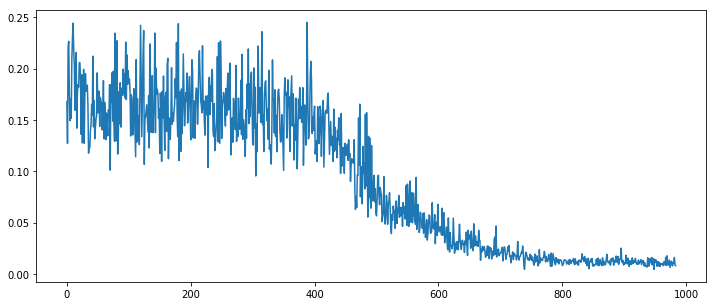

In [13]:
import matplotlib.pyplot as plt

# remove noise from initial epochs
loss_history_plot = list(filter(lambda x: x < 0.25, loss_history))

plt.figure(figsize=(12, 5))
plt.plot(loss_history_plot)
# plt.show()

# Observations
The model does train for 100 timesteps quite quickly, but it doesnt match the speed of learning by the paper. In the paper, the loss starts to drop close to the 300th iteration and drops all the way to the low 0.0x by the 425th iteration.

Here the loss starts to reduce at the 400th iteration and drops completely by the 600th iteration, much slower than the paper. Also, I had to clip off the first few iterations with extremely high losses as the graph cannot be visualized properly if they were kept.

#  Loading Checkpoints

Tensorflow Eager makes loading of checkpoints that are fully contained in a Keras model easy. However, there is one small idiosynchacy that needs to be dealt with when loading models in TF 1.7.

Models, after being build, need to be called at least once prior to the checkpoint restoring their weights. If this is not done, it throws obscure errors.

In [15]:
if os.path.exists(CHECKPOINTS_DIR):
    ckpt_path = tf.train.latest_checkpoint(CHECKPOINTS_DIR)
    print("Checkpoint path : ", ckpt_path)

    model = JANETModel(NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS, output_activation='linear')

    model.compile(tf.train.AdamOptimizer(), loss='mse')
    
    # this is where you need to call the model at least once,
    # so that all of its variables can be properly restored
    zeros = tf.zeros((1, TIME_STEPS, 2))
    model(zeros)
    
    # restore the weights
    tfe.Checkpoint(model=model, ).restore(ckpt_path)
    
    # predict one batch to ensure the weights are correctly loaded
    generator = batch_generator()

    losses = []
    for i in range(20):
        inputs, outputs = next(generator)

        preds = model(inputs)
        loss_val = loss(outputs, preds)

        losses.append(loss_val.numpy())

    print("Final average predicted error (should be less than 0.03) : ", np.mean(losses))

Checkpoint path :  checkpoints_addition/addition_janet.ckpt-1


Final average predicted error (should be less than 0.03) :  0.011101311


# Stepping off the well trodden path
When building keras models that **only** use Keras layers, there is no issue when loading or saving weights.

However, not every thing can be represented in layers, and a few models may require working directlty with TF Eager variables. In such cases, a different approach is required to save and restore these models.

Lets see the same model without using Keras layers to define them. Here to keep it simple, we will use Eager variables to define the RNN cell, and a Keras Layer to define the classification / regression layer.

In [16]:
class EagerJANETModel(tf.keras.Model):
    
    def __init__(self, input_dim, units, num_outputs, num_timesteps, output_activation='sigmoid', **kwargs):
        super(EagerJANETModel, self).__init__(**kwargs)
        
        self.input_dim = input_dim
        self.units = units
        self.classes = num_outputs
        self.num_timesteps = num_timesteps

        # Initialize the forget gate with ChronoInitializer
        # The memory gate is initialized with zeros
        with tf.device(_device):
            def bias_initializer(_, *args, **kwargs):
                forget_gate = ChronoInitializer(self.num_timesteps)((self.units,), *args, **kwargs)
                
                return tf.keras.backend.concatenate([
                    forget_gate,
                    tf.keras.initializers.Zeros()((self.units,), *args, **kwargs),
                ])
            
            # Initialize the hidden and recurrent gates
            self.kernel = tf.get_variable('kernel', shape=[input_dim, units * 2], dtype=tf.float32,
                                          initializer=tf.keras.initializers.glorot_uniform())
            
            self.recurrent_kernel = tf.get_variable('recurrent_kernel', shape=[units, units * 2], dtype=tf.float32,
                                                    initializer=tf.keras.initializers.glorot_uniform())
            
            self.recurrent_bias = tf.get_variable('recurrent_bias', shape=[units * 2], dtype=tf.float32,
                                                  initializer=bias_initializer)
            
            # Initialize the final layer (for classification or regression depending on the output activation)
            self.output_dense = tf.keras.layers.Dense(num_outputs, activation=output_activation)
        
        # we need to create a dictionary of all of the weights which are not in Keras layers
        self.additional_weights = OrderedDict()
        self.additional_weights[self.kernel.name] = self.kernel
        self.additional_weights[self.recurrent_kernel.name] = self.recurrent_kernel
        self.additional_weights[self.recurrent_bias.name] = self.recurrent_bias
        
    
    """
    This is required to override a certain issue with how the weights of a model are loaded
    by a checkpoint.
    
    While we could use `model.call(inputs)` directly, the more pythonic way of doing this is
    by using `model(inputs)`.
    
    However, in Eager mode, the ordinary function call does *not* forward the method to the
    models `call` method. This bypasses that issue.
    """
    def __call__(self, *args, **kwargs):
        if not tf.executing_eagerly():
            super(EagerJANETModel, self).__call__(*args, **kwargs)
        return self.call(*args, **kwargs)

    def call(self, inputs, training=None, mask=None):
        # Initialize the hidden memory states
        outputs = []
        states = []
        
        with tf.device(_device):
            h_state = tf.zeros((inputs.shape[0], self.units))
            c_state = tf.zeros((inputs.shape[0], self.units))
            
            # Input is in the shape [None, timesteps, input_dim]
            for t in range(inputs.shape[1]):
                ip = inputs[:, t, :]  # access the T'th timestep
                
                # Perform the forward pass of the model
                z = tf.matmul(ip, self.kernel)
                z += tf.matmul(h_state, self.recurrent_kernel) + self.recurrent_bias
                
                # Split the output into the forget and memory outputs
                z0 = z[:, :self.units]
                z1 = z[:, self.units: 2 * self.units]
    
                # gate updates
                f = tf.keras.activations.sigmoid(z0)
                c = f * c_state + (1. - f) * tf.nn.tanh(z1)
    
                # state updates
                h = c
                
                # update our previous state
                h_state = h
                c_state = c
            
                # preserve the history of our states
                outputs.append(h)
                states.append([h])  # here we maintain just 1 state variable, can be more
                
            # save memory states to global variables so we can access them later
            # self.cell_outputs = tf.stack(outputs, axis=1)
            # self.cell_states = states
            
            # perform forward pass of the classifier / regressor
            preds = self.output_dense(outputs[-1])

            return preds

# Gradients of a custom model

The gradients of such a model are a little more complicated than the earlier simple `model.trainable_variables`. Since tf.keras Models do not track the weights that are added separately (apart from keras layers, no weights or variables are managed by Keras), we need to write a custom grad function.

In [17]:
def grad(model, X, y):
    with tf.device(_device):
        with tf.GradientTape() as tape:
            preds = model(X)
            loss_val = loss(y, preds)
        
        # this is the crucial step : use the dictionary of weights that we manage
        # manually to get all of the weights that are not managed by keras and add
        # them to the list of weights for which we need gradients
        vars = model.trainable_variables + list(model.additional_weights.values())
        grads = tape.gradient(loss_val, vars)
        grad_vars = zip(grads, vars)

        return grad_vars, loss_val

# Reason for custom gradient function

Keras has two very convenient methods `add_weight` and `add_variable` to add weights to a layer / model easily. However, TF Eager mode has not implemented these methods yet, and therefore we cant use them directly.

Therefore, we have to take the roundabout way of mixing Keras layers with custom weights and keep a track of them using a dictionary.

# Training and Saving the weights of a custom model

Saving and restoring of custom models is exactly the same as before if you are using tf.get_variable to create variables in Eager mode. However, tfe.Variable() is NOT managed by keras, so don't use it inside a Keras model.

In [18]:
%%time
input_dim = 2
model = EagerJANETModel(input_dim, NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS, output_activation='linear')

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
global_step = tf.train.get_or_create_global_step()

# try using different optimizers and different optimizer configs
model.compile(loss='mse', optimizer=optimizer)

best_loss = 100.
generator = batch_generator()

loss_history = []
update_counter = 1

for epoch in range(NUM_EPOCHS):
    print("Epoch # : ", epoch + 1)

    for step in range(STEPS_PER_EPOCH):
        # get batch dataset
        inputs, targets = next(generator)

        # get gradients and loss at this iteration (uses the new grad method)
        gradients, loss_val = grad(model, inputs, targets)

        # apply gradients
        optimizer.apply_gradients(gradients, tf.train.get_or_create_global_step())

        loss_history.append(loss_val.numpy())
        print(update_counter, ":", loss_history[-1])

        update_counter += 1

    print()

    # remove old checkpoint that we no longer need
    if os.path.exists(CHECKPOINTS_DIR):
        shutil.rmtree(CHECKPOINTS_DIR)

    # save the checkpoint weights
    # Note how we add the model's additional weights as name-variable pairs
    checkpoint = tfe.Checkpoint(model=model).save(CHECKPOINT_PATH)

    # Optional : Save the weight matrices in Keras format as well
    #model.save_weights('addition_model.h5', overwrite=True)

    print("Saving weights")
    print()
print()


Epoch # :  1


1 : 1.1863205


2 : 1.0825965


3 : 1.1078988
4

 : 1.0668939
5 : 

0.8775318
6 : 0.9191616
7 : 0.7604675


8 : 0.6220919


9 : 0.615086


10 : 0.39194804
11

 : 0.2522026


12 : 0.1929467
13 : 0.13068408


14 : 0.36698163
15 : 0.39257798


16 : 0.32155538


17 : 0.21351986


18 : 0.15593475
19

 : 0.18594776
20

 : 0.15899421
21

 : 0.23217717


22 : 0.23954311


23 : 0.20241736


24 : 0.25740024


25 : 0.29807895


26 : 0.3052492


27 : 0.22836111


28 : 0.26137054


29 : 0.25836453


30 : 0.15520325


31 : 0.14407538


32 : 0.19183467


33 : 0.20594029
34 : 0.32778102


35 : 0.3024955


36 : 0.21141835


37 : 0.15211546
38 : 0.19563393


39 : 0.14108545
40

 : 0.13442862


41 : 0.20500633
42 : 0.1612525


43 : 0.18532173


44 : 0.18569846


45 : 0.16968986
46

 : 0.12340805
47

 : 0.17430797


48 : 0.18686515


49 : 0.21190976
50 : 0.14499529


51 : 0.16780232
52

 : 0.2446912
53 : 0.17020866


54 : 0.15005301
55 : 0.1709134


56 : 0.16863212


57 : 0.13903871
58 : 0.11667651


59 : 0.16236314
60 : 0.17771359


61 : 0.15818122
62 : 0.1787187


63 : 0.16717957
64 : 0.13323289


65 : 0.18707603
66 : 0.20518379


67 : 0.15378405
68 : 0.136622


69 : 0.17231646
70 : 0.162741


71 : 0.15120059
72 : 0.16198596


73 : 0.19679745
74 : 0.13938366


75 : 0.12319234
76 : 0.16187659


77 : 0.16021708
78 : 0.16791578


79 : 0.17191415
80 : 0.16724847


81 : 0.14357433
82 : 0.18213236


83 : 0.13477916
84 : 0.12831531


85 : 0.19639868
86 : 0.19013506


87 : 0.1740538
88 : 0.13955764


89 : 0.13083582
90 : 0.13832274


91 : 0.16457488
92 : 0.18168087


93 : 0.15546733
94 : 0.19978154


95 : 0.13187733
96

 : 0.20618378


97 : 0.17945996
98 : 0.19089869


99 : 0.19370812
100 : 0.15767057



Saving weights

Epoch # :  2
101 : 0.18387584


102 : 0.15744102
103 : 0.19165348


104 : 0.15445054


105 : 0.19755165
106 : 0.1567266


107 : 0.19496861
108 : 0.17413841


109 : 0.17989075
110 : 0.15451969


111 : 0.13978714
112 : 0.14743064


113 : 0.17114781
114

 : 0.13507229
115 : 0.18055117


116 : 0.15782249
117 : 0.14237398


118 : 0.16557777
119 : 0.17426163


120 : 0.14292641


121 : 0.14203987
122 : 0.17363375


123 : 0.099661686
124 : 0.1830413


125 : 0.20544976
126 : 0.17641792


127 : 0.16301957
128 : 0.15461187


129 : 0.15706742
130 : 0.11461704


131 : 0.2027565
132 : 0.18444005


133 : 0.14352888
134 : 0.105158046


135 : 0.14627554
136 : 0.1787536


137 : 0.15321855
138 : 0.15683888


139 : 0.11505594
140 : 0.18271084


141 : 0.13358566
142 : 0.15559794


143 : 0.17392962
144 : 0.13415056


145 : 0.13467284
146 : 0.10924814


147 : 0.16471323
148 : 0.12387948


149 : 0.15421179
150 : 0.1326867


151 : 0.15494223
152 : 0.14235674


153 : 0.13341394
154 : 0.12667082


155 : 0.14434633
156 : 0.15618463


157 : 0.16903406


158 : 0.11429178
159 : 0.1595455


160 : 0.18396683


161 : 0.14064975
162 : 0.12328291


163 : 0.1327574
164 : 0.10899836


165 : 0.1490691
166 : 0.17142387


167 : 0.18720062
168 : 0.14594021


169 : 0.14904119
170 : 0.12678112


171 : 0.18775502
172 : 0.16270094


173 : 0.19385813
174 : 0.11920126


175 : 0.15955281
176 : 0.14483856


177 : 0.17450312
178 : 0.20242679


179 : 0.17479339
180 : 0.18003102


181 : 0.18169674
182

 : 0.14804004
183 : 0.15493755


184 : 0.15627818


185 : 0.15011175
186 : 0.12486178


187 : 0.13262033
188 : 0.12453003


189 : 0.19436556
190 : 0.13916849


191 : 0.15625463
192

 : 0.18758911


193 : 0.20431493
194 :

 0.13885792
195 : 0.18899389
196 : 0.18787792


197 : 0.19755727
198 : 0.20649628


199 : 0.13795367


200 : 0.1341619

Saving weights

Epoch # :  3


201 : 0.13548887
202

 : 0.1595162
203

 : 0.217491
204

 : 0.13713448


205 : 0.20237918
206 : 0.15341938


207 : 0.17038365
208 : 0.15939398


209 : 0.18556866


210 : 0.16775908
211

 : 0.26038718
212 : 0.15292971


213 : 0.15089668
214 : 0.22657646


215 : 0.15638737
216 : 0.16247836


217 : 0.15031675
218 : 0.15152365


219 : 0.18735184
220 : 0.12936342


221 : 0.1532566
222 : 0.15206341


223 : 0.15328345
224 : 0.15624617


225 : 0.2088171
226 : 0.16056778


227 : 0.1330771
228 : 0.12922159


229 : 0.17094101
230 : 0.17673393


231 : 0.17510845
232 : 0.12495825


233 : 0.15233776
234 : 0.14903629


235 : 0.16914962
236 : 0.18132778


237 : 0.15152611
238 : 0.16099113


239 : 0.17538065
240 : 0.14669436


241 : 0.13299403
242 : 0.15519363


243 : 0.16138764
244 : 0.13110855


245 : 0.16091049
246 : 0.1469284


247 : 0.12687422
248 : 0.16108698


249 : 0.1975203
250 : 0.164016


251 : 0.15859807
252 : 0.16948979


253 : 0.13900563
254 : 0.20029552


255 : 0.17458418
256 : 0.1411032


257 : 0.14799662
258 : 0.16268674


259 : 0.13446182
260 : 0.15146837


261 : 0.13526267
262 : 0.18256637


263 : 0.19080143
264 : 0.18717661


265 : 0.13666421
266 : 0.15079914


267 : 0.17735405
268 : 0.1838001


269 : 0.111649275
270

 : 0.16416153
271 : 0.14342238


272 : 0.15484253


273 : 0.15816763
274 : 0.12626672


275 : 0.1366295
276 : 0.16388765


277 : 0.17567572
278 : 0.13676792


279 : 0.13602568
280 : 0.1331036


281 : 0.17319185
282 : 0.12718914


283 : 0.14714889
284 : 0.19522278


285 : 0.1952913
286 : 0.1345443


287 : 0.163543
288 : 0.2090792


289 : 0.20652458
290 : 0.16876233


291 : 0.14751549
292 : 0.16784416


293 : 0.17308319
294 : 0.20645456


295 : 0.20239641
296 : 0.16699688


297 : 0.13925524
298 : 0.14306393


299 : 0.16496071
300 : 0.14095303



Saving weights

Epoch # :  4
301 : 0.16527365


302 : 0.15110832
303 : 0.1944037


304 : 0.23938763


305 : 0.16669568
306

 : 0.15069176
307 : 0.19259986


308 : 0.15497479
309 : 0.13593563


310 : 0.13170132
311 : 0.18818337


312 : 0.16391514


313 : 0.12909196
314 : 0.14935614


315 : 0.17156401
316 : 0.17152193


317 : 0.124549255
318 : 0.14318904


319 : 0.14157848
320 : 0.18627822


321 : 0.16004114
322 : 0.10258955


323 : 0.17237438
324 : 0.12817304


325 : 0.13095537
326 : 0.16484839


327 : 0.17766838
328 : 0.18566944


329 : 0.15650134
330 : 0.16153316


331 : 0.10119503
332 : 0.1605059


333 : 0.17737621
334 : 0.15578365


335 : 0.15625478
336 : 0.15357181


337 : 0.157081
338 : 0.1767764


339 : 0.13025439
340 : 0.16889982


341 : 0.16774847
342 : 0.22029428


343 : 0.2177193
344 : 0.19423497


345 : 0.18305181
346 : 0.14641845


347 : 0.21564247
348 : 0.17686138


349 : 0.14250553


350 : 0.19360897
351 : 0.16480003


352 : 0.15939401


353 : 0.16601624
354 : 0.16549453


355 : 0.16601707
356 : 0.1924931


357 : 0.17000042
358 : 0.14883445


359 : 0.1414828
360

 : 0.18825614


361 : 0.14909491
362 : 0.14882185


363 : 0.12613475
364 : 0.18254703


365 : 0.1697703


366 : 0.12848085
367

 : 0.14147371


368 : 0.21602735


369 : 0.13107306


370 : 0.108254306
371 : 0.1579496


372 : 0.1631909
373 : 0.17584473


374 : 0.1491352


375 : 0.16112834


376 : 0.15501057


377 : 0.17422706


378 : 0.16119063


379 : 0.1132967


380 : 0.17578807


381 : 0.11741868


382 : 0.15410474
383

 : 0.115864
384

 : 0.16167611


385 : 0.1307642
386

 : 0.12057106
387 : 0.13724928


388 : 0.19056809
389

 : 0.122192614


390 : 0.13473396
391

 : 0.12611
392

 : 0.13698006


393 : 0.12520444
394

 : 0.13966478
395 :

 0.12028929
396 : 0.08115202
397 : 0.17289375


398 : 0.121010534
399

 : 0.16420269
400 : 0.1766406



Saving weights

Epoch # :  5


401 : 0.15197049
402 : 0.13378225


403 : 0.15281829
404 : 0.17709719


405 : 0.13661525
406 : 0.096494086


407 : 0.18895175
408 : 0.18288521


409 : 0.1535454
410 : 0.14978424


411 : 0.18356493
412 : 0.124196246


413 : 0.113138735
414 : 0.14847586


415 : 0.15149876
416 : 0.13064922


417 : 0.14805412
418 : 0.1669496


419 : 0.081941694
420 : 0.18405396


421 : 0.123199254
422 : 0.1309464


423 : 0.15731879
424 : 0.18882759


425 : 0.13715102
426 : 0.12817487


427 : 0.11223705
428 : 0.118986264


429 : 0.15446672
430 : 0.16728519


431 : 0.13747579
432 : 0.17647927


433 : 0.15965556
434 : 0.15521984


435 : 0.16095604
436 : 0.17172581


437 : 0.14220399
438 : 0.122825496


439 : 0.11685846
440 : 0.16871645


441 : 0.15552805
442 : 0.1340239


443 : 0.1349995
444 : 0.14816949


445 : 0.11945558
446 : 0.1494511


447 : 0.08515044
448 : 0.10708694


449 : 0.08957674
450 : 0.13689712


451 : 0.12711656
452 : 0.10547689


453 : 0.15670979
454 : 0.14418907


455 : 0.129047
456 : 0.13010806


457 : 0.09756214
458 : 0.1420194


459 : 0.16443928
460 : 0.09934924


461 : 0.16382422
462 : 0.12820221


463 : 0.13440724
464 : 0.10266583


465 : 0.09560459
466 : 0.11559576


467 : 0.13053097
468 : 0.16898948


469 : 0.11483173
470 : 0.14887832


471 : 0.1539184
472 : 0.08048336


473 : 0.0857097
474 : 0.12262388


475 : 0.112770885
476 : 0.06983276


477 : 0.13397762
478 : 0.09622431


479 : 0.13905868
480 : 0.108339414


481 : 0.11325115
482 : 0.10019961


483 : 0.09163653
484 : 0.14794244


485 : 0.12756397
486 : 0.08185114


487 : 0.115393765
488 : 0.11416923


489 : 0.11289977
490 : 0.12128005


491 : 0.116888806
492

 : 0.10293217
493 : 0.11479988


494 : 0.099466175
495 : 0.08507814


496 : 0.073563635


497 : 0.089378946
498 : 0.09141354


499 : 0.10822956
500 : 0.08505208



Saving weights

Epoch # :  6
501

 : 0.069293715
502 : 0.10578907


503 : 0.091613635
504 : 0.066864125


505 : 0.13328281
506 : 0.06497024


507 : 0.104907855
508 : 0.09725441


509 : 0.06739021
510 : 0.07607546


511 : 0.07719852
512 : 0.06519877


513 : 0.08166614
514 : 0.08557967


515 : 0.07692634
516 : 0.06576989


517 : 0.05207384
518 : 0.07377081


519 : 0.08558691
520 : 0.06338585


521 : 0.07478403
522 : 0.05711462


523 : 0.0658528
524 : 0.061191402


525 : 0.05360418
526 : 0.04981256


527 : 0.057684053
528 : 0.063291386


529 : 0.06738666
530 : 0.0554298


531 : 0.049198303
532 : 0.07566271


533 : 0.07984219
534 : 0.06544967


535 : 0.07315405
536 : 0.0847258


537 : 0.062495653
538 : 0.058947697


539 : 0.06351213
540 : 0.056836367


541 : 0.099845655
542 : 0.06681452


543 : 0.08044393
544 : 0.06460344


545 : 0.05249507
546 : 0.052269373


547 : 0.05495489
548 : 0.058491066


549 : 0.065151446
550 : 0.06941429


551 : 0.04829691
552 : 0.06600593


553 : 0.07399958
554 : 0.06291454


555 : 0.08226039
556 : 0.050521515


557 : 0.06874852
558 : 0.048835773


559 : 0.079564415
560 : 0.059467662


561 : 0.08160885
562 : 0.048336487


563 : 0.061923627
564 : 0.041441575


565 : 0.06470303
566 : 0.042430006


567 : 0.053933248
568 : 0.06300385


569 : 0.06907927
570 : 0.053334303


571 : 0.06253871
572 : 0.042707585


573 : 0.056704096
574 : 0.052638218


575 : 0.055826154
576 : 0.047564343


577 : 0.062947586
578 : 0.06350876


579 : 0.054984555
580 : 0.05601598


581 : 0.051924925
582 : 0.06668033


583 : 0.044050455
584 : 0.07805016


585 : 0.042617742
586 : 0.066679664


587 : 0.0683327
588 : 0.07937528


589 : 0.048178982
590 : 0.08115402


591 : 0.056167822
592 : 0.050994396


593 : 0.06042539
594 : 0.054591384


595 : 0.0502483
596 : 0.06566024


597 : 0.03916175
598 : 0.052660875


599 : 0.041440967
600 : 0.05469115



Saving weights

Epoch # :  7


601 : 0.041439846
602 : 0.046232942


603 : 0.03984015
604 : 0.050228506


605 : 0.051855255
606 : 0.05332586


607 : 0.04681224
608 : 0.044613093


609 : 0.035331715
610 : 0.04591154


611 : 0.03143496
612 : 0.0481059


613 : 0.04735215
614 : 0.053161666


615 : 0.044266626
616 : 0.04289397


617 : 0.04876983
618 : 0.04817506


619 : 0.048061743
620 : 0.04336541


621 : 0.04130238
622 : 0.04436686


623 : 0.037688587
624 : 0.04950376


625 : 0.022705398
626 : 0.05092592


627 : 0.04866819
628 : 0.037487265


629 : 0.06814576
630 : 0.03727596


631 : 0.056108665
632 : 0.047742277


633 : 0.05197091
634 : 0.042601604


635 : 0.04380659
636 : 0.04899147


637 : 0.067419976
638 : 0.03222012


639 : 0.04956126
640 : 0.038642094


641 : 0.028166091
642

 : 0.06857498
643 : 0.034645647


644 : 0.034372948
645 : 0.03768577


646 : 0.031247787
647 : 0.0401386


648 : 0.033139173


649 : 0.031720005
650 : 0.020832801


651 : 0.026312608
652 : 0.04248183


653 : 0.02665153
654 : 0.030700445


655 : 0.024023468
656 : 0.027774904


657 : 0.028906433
658 : 0.02892302


659 : 0.032491043
660 : 0.017954463


661 : 0.024146516
662 : 0.029904451


663 : 0.036750007
664 : 0.02395837


665 : 0.027062295
666 : 0.02073616


667 : 0.032016814
668 : 0.022456747


669 : 0.023033243
670 : 0.02679782


671 : 0.032024406
672 : 0.03308885


673 : 0.02417243
674 : 0.040474385


675 : 0.036072813
676 : 0.034477882


677 : 0.040182646
678 : 0.016068218


679 : 0.035703767
680 : 0.021527782


681 : 0.03252659
682 : 0.05660139


683 : 0.032539725
684 : 0.057534713


685 : 0.0344289
686 : 0.02859387


687 : 0.05887813
688 : 0.018142594


689 : 0.04528752
690 : 0.03539994


691 : 0.027390957
692 : 0.05250129


693 : 0.034107115
694 : 0.034082297


695 : 0.041782178
696 : 0.024494719


697 : 0.033270426
698 : 0.036992703


699 : 0.018612351
700 : 0.028702423



Saving weights

Epoch # :  8
701 : 0.02702353


702 : 0.014002624
703 : 0.02444316


704 : 0.021080578


705 : 0.018750038
706 : 0.021868639


707 : 0.022204481
708 : 0.017288966


709 : 0.019015089
710 : 0.016730616


711 : 0.02371124
712 : 0.02222113


713 : 0.023729052
714 : 0.0230922


715 : 0.024243595
716 : 0.010098998


717 : 0.013166981
718 : 0.017533317


719 : 0.018744415
720 : 0.024562402


721 : 0.020151816
722 : 0.017487563


723 : 0.015773008
724 : 0.014746145


725 : 0.018279273
726 : 0.028086534


727 : 0.017874818
728 : 0.024570374


729 : 0.019041017
730 : 0.028905777


731 : 0.02110329
732 : 0.014131172


733 : 0.01937785
734 : 0.022271853


735 : 0.015826356
736 : 0.020285439


737 : 0.01585445
738 : 0.01774655


739 : 0.019587833
740 : 0.011868105


741 : 0.016448103
742 : 0.017067133


743 : 0.023632808
744 : 0.017648496


745 : 0.021532422
746 : 0.019318597


747 : 0.023708472
748 : 0.018883929


749 : 0.019081559
750 : 0.025206046


751 : 0.016531827
752 : 0.023219097


753 : 0.016901886
754 : 0.021113921


755 : 0.0155975595
756 : 0.011947424


757 : 0.0214095
758 : 0.02123854


759 : 0.013500904
760 : 0.025345998


761 : 0.01744945
762 : 0.01569806


763 : 0.011885681
764 : 0.020290615


765 : 0.016119568
766 : 0.010971039


767 : 0.021215437
768 : 0.016490279


769 : 0.019432083
770 : 0.01661498


771 : 0.0189452
772 : 0.023697263


773 : 0.017829724
774 : 0.008294834


775 : 0.022505034
776 : 0.017726619


777 : 0.016067294
778 : 0.016965626


779 : 0.021295303
780 : 0.014807629


781 : 0.026293088
782 : 0.023869352


783 : 0.02665699
784 : 0.015875228


785 : 0.02459177
786 : 0.017835952


787 : 0.014164188
788 : 0.027498636


789 : 0.016721308
790 : 0.015938718


791 : 0.023103526
792 : 0.019169789


793 : 0.023055263
794 : 0.01835302


795 : 0.012493304
796 : 0.023566231


797 : 0.020593166
798 : 0.02302548


799 : 0.021364253
800 : 0.02632725



Saving weights

Epoch # :  9


801 : 0.012144689
802 : 0.021969538


803 : 0.018669523
804 : 0.018257637


805 : 0.02421519
806 : 0.024318585


807 : 0.020420983
808 : 0.010221038


809 : 0.021923276
810 : 0.012339222


811 : 0.021437183
812 : 0.020779459


813 : 0.012053227
814 : 0.018199084


815 : 0.011400741
816 : 0.01236902


817 : 0.010120714
818 : 0.013969452


819 : 0.017219124
820 : 0.015326751


821 : 0.020597873
822 : 0.018005667


823 : 0.02245377
824 : 0.014368331


825 : 0.031000033
826 : 0.016904952


827 : 0.031646673
828 : 0.032851815


829 : 0.017661832
830 : 0.033717744


831 : 0.012044613
832 : 0.02663999


833 : 0.014198474
834 : 0.0169551


835 : 0.018859942
836 : 0.017868705


837 : 0.019282877
838 : 0.018924763


839 : 0.019194888
840 : 0.023630224


841 : 0.015664384
842 : 0.018490683


843 : 0.019811748
844 : 0.021178212


845 : 0.021488933
846 : 0.024084987


847 : 0.014982278
848 : 0.019473001


849 : 0.015390527
850 : 0.014729774


851 : 0.01414384
852 : 0.009720401


853 : 0.018830784
854 : 0.017744428


855 : 0.016262185
856

 : 0.022299245


857 : 0.017834025
858 : 0.0139529435


859 : 0.014881597
860 : 0.0138254585


861 : 0.009610896
862 : 0.023048783


863 : 0.01763593
864 : 0.016210172


865 : 0.0135910055
866 : 0.014613352


867 : 0.010658455
868 : 0.01357085


869 : 0.018297963
870 : 0.016050408


871 : 0.0150260925
872 : 0.023191867


873 : 0.01949325
874 : 0.0133226765


875 : 0.019906983
876 : 0.013182271


877 : 0.017442219
878 : 0.015668424


879 : 0.014447076
880 : 0.01898337


881 : 0.015271635
882 : 0.016754035


883 : 0.013357544
884 : 0.012483958


885 : 0.009928305
886 : 0.012434965


887 : 0.018889291
888 : 0.016825048


889 : 0.008681259
890 : 0.019221537


891 : 0.01603935
892 : 0.018575924


893 : 0.037076898
894 : 0.012639243


895 : 0.04325118
896 : 0.024188245


897 : 0.017682826
898 : 0.020115826


899 : 0.020209868
900 : 0.011096585



Saving weights

Epoch # :  10
901 : 0.018660523


902 : 0.023436151
903 : 0.020422306


904 : 0.012974851


905 : 0.019302223
906 : 0.018483704


907 : 0.0094721485
908 : 0.014757791


909 : 0.017632108
910 : 0.023749514


911 : 0.016331775
912 : 0.017452583


913 : 0.013443633
914 : 0.017618528


915 : 0.02246584
916 : 0.020524792


917 : 0.012854662
918

 : 0.03331028
919 : 0.010226913


920 : 0.015002587


921 : 0.025855165
922

 : 0.017893918
923 : 0.014592928


924 : 0.021368204
925 : 0.017633224


926 : 0.011746512
927 : 0.021985283


928 : 0.01631511


929 : 0.010333984
930 : 0.010262552


931 : 0.016359454
932 : 0.014762308


933 : 0.010311926
934 : 0.013914411


935 : 0.011044102
936 : 0.0129837105


937 : 0.012697223
938 : 0.017520668


939 : 0.020861344
940 : 0.016407872


941 : 0.01827773
942 : 0.012268904


943 : 0.016127765
944 : 0.011566348


945 : 0.013481025
946 : 0.015919277


947 : 0.011427705
948 : 0.007901485


949 : 0.015871689
950

 : 0.013263435
951 : 0.017574826


952 : 0.01395469


953 : 0.012412896
954 : 0.020395404


955 : 0.014286202
956 : 0.012992325


957 : 0.013233131
958 : 0.013650877


959 : 0.016537553
960 : 0.016890349


961 : 0.012278471
962 : 0.013373372


963 : 0.009354684
964 : 0.010743004


965 : 0.019569186
966 : 0.018581277


967 : 0.018475642
968 : 0.012160343


969 : 0.012117587
970 : 0.013282405


971 : 0.021491313
972 : 0.012178303


973 : 0.014342352
974 : 0.018429685


975 : 0.010699254
976 : 0.011105149


977 : 0.021861758
978 : 0.01207587


979 : 0.011735147
980 : 0.020310225


981 : 0.016673716
982 : 0.020663625


983 : 0.027488561
984 : 0.017123748


985 : 0.021256432
986 : 0.023598


987 : 0.017707923
988 : 0.018361391


989 : 0.017040992
990 : 0.0145074865


991 : 0.011934569
992 : 0.022113957


993 : 0.026698379
994 : 0.01746341


995 : 0.024781022
996 : 0.016044661


997 : 0.011120651
998 : 0.01891048


999 : 0.021428071
1000 : 0.014277417



Saving weights


Wall time: 3min 9s


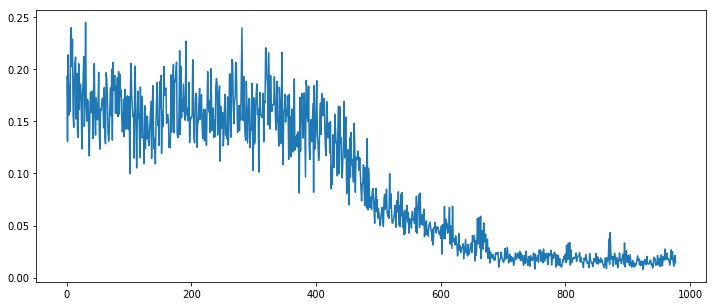

In [19]:
# remove noise from initial epochs
loss_history_plot = list(filter(lambda x: x < 0.25, loss_history))

plt.figure(figsize=(12, 5))
plt.plot(loss_history_plot)

# Restoring custom models

Because of the added complexity of saving hybrid models, we need to have a slightly different method to load the weights of the custom model from the checkpoint.

In [20]:
if os.path.exists(CHECKPOINTS_DIR):
    ckpt_path = tf.train.latest_checkpoint(CHECKPOINTS_DIR)
    print("Checkpoint path : ", ckpt_path)

    model = EagerJANETModel(input_dim, NUM_UNITS, num_outputs=1, num_timesteps=TIME_STEPS, output_activation='linear')

    model.compile(tf.train.AdamOptimizer(), loss='mse')
    
    # this is where you need to call the model at least once,
    # so that all of its variables can be properly restored
    zeros = tf.zeros((1, TIME_STEPS, 2))
    model(zeros)
    
    # restore the weights
    # see the difference as to how we pass the additional weight matrices to be loaded
    tfe.Checkpoint(model=model).restore(ckpt_path)
    
    # predict one batch to ensure the weights are correctly loaded
    generator = batch_generator()

    losses = []
    for i in range(20):
        inputs, outputs = next(generator)

        preds = model(inputs)
        loss_val = loss(outputs, preds)

        losses.append(loss_val.numpy())

    print("Final average predicted error (should be less than 0.03) : ", np.mean(losses))

Checkpoint path :  checkpoints_addition/addition_janet.ckpt-1


Final average predicted error (should be less than 0.03) :  0.018639356
